In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm

In [2]:
area_feature_training_sample = pd.read_csv('../../data/pre_training/area_feature_training_sample.csv')
area_target_training_sample = pd.read_csv('../../data/pre_training/area_target_training_sample.csv')
district_feature_training_sample = pd.read_csv('../../data/pre_training/district_feature_training_sample.csv')
district_target_training_sample = pd.read_csv('../../data/pre_training/district_target_training_sample.csv')

In [3]:
area_feature_training_sample.drop('crime_status', axis=1, inplace=True)
district_feature_training_sample.drop('crime_status', axis=1, inplace=True)

In [4]:
area_feature_testing_data = pd.read_csv('../../data/pre_training/area_feature_testing_data.csv')
area_target_testing_data = pd.read_csv('../../data/pre_training/area_target_testing_data.csv')
district_feature_testing_data = pd.read_csv('../../data/pre_training/district_feature_testing_data.csv')
district_target_testing_data = pd.read_csv('../../data/pre_training/district_target_testing_data.csv')

In [5]:
def generate_correlation_heatmap(df, figsize, title, save_name):
    # Generate a mask to onlyshow the bottom triangle
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))

    # generate heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
    plt.title(title)
    plt.savefig(f'../results/linear_regression/{save_name}.png')
    plt.show()

##### Using VIF to Remove Multicollinearity

In [6]:
# Function to compute VIF for all features
def compute_vif(feature_df):
    print(f"{datetime.now()} - Starting VIF computation")
    X = feature_df.copy()
    # The calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # Create dataframe to store VIF values
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['feature'] != 'intercept']
    
    print(f"{datetime.now()} - Completed VIF computation")
    return vif

In [7]:
# Function to optimize VIF by dropping features with high VIF values
def optimize_vif(feature_df, vif_threshold):
    print(f"{datetime.now()} - Starting VIF optimization")
    df = feature_df.copy()       

    vif_df = compute_vif(feature_df)
    
    while (vif_df['vif'] >= vif_threshold).any():
        print(f"{datetime.now()} - Current VIF values:\n{vif_df}")
        largest_vif_feature = vif_df.loc[vif_df['vif'].idxmax(), 'feature']
        print(f"{datetime.now()} - Dropping feature: {largest_vif_feature} with VIF score of: {vif_df['vif'].max()}")
        df = df.drop(columns=[largest_vif_feature])
        vif_df = compute_vif(df)
    
    print(f"{datetime.now()} - Completed VIF optimization")
    return vif_df

In [8]:
area_selected_features_ten = optimize_vif(area_feature_training_sample, 10)

2024-08-06 15:39:09.269636 - Starting VIF optimization
2024-08-06 15:39:09.507635 - Starting VIF computation
2024-08-06 16:08:51.216767 - Completed VIF computation
2024-08-06 16:08:51.243768 - Current VIF values:
                      feature        vif
0                         day   1.001530
1                        hour   1.129163
2                        year   1.912695
3                       month   1.026154
4                 day_of_week   1.009033
..                        ...        ...
79   area_crimes_6_hours_prev  19.853698
80  area_crimes_12_hours_prev  35.809665
81  area_crimes_24_hours_prev  40.268734
82     area_id_target_encoded  12.275894
83       area_id_freq_encoded  22.142840

[84 rows x 2 columns]
2024-08-06 16:08:51.246767 - Dropping feature: bike_rides_within_0.5_and_10_min with VIF score of: 401.4052943825488
2024-08-06 16:08:51.806767 - Starting VIF computation
2024-08-06 16:37:30.001804 - Completed VIF computation
2024-08-06 16:37:30.032803 - Current VIF value

In [9]:
district_selected_features_ten = optimize_vif(district_feature_training_sample, 10)

2024-08-07 01:04:47.880796 - Starting VIF optimization
2024-08-07 01:04:47.964796 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:09:24.958853 - Completed VIF computation
2024-08-07 01:09:24.966854 - Current VIF values:
                      feature        vif
0                         day   1.001356
1                        hour   1.148054
2                        year   2.056838
3                       month   1.018993
4                 day_of_week   1.009792
..                        ...        ...
78   area_crimes_6_hours_prev  18.058965
79  area_crimes_12_hours_prev  32.262040
80  area_crimes_24_hours_prev  31.887524
81    district_target_encoded   2.497593
82      district_freq_encoded   0.323271

[83 rows x 2 columns]
2024-08-07 01:09:24.967857 - Dropping feature: bike_rides_within_0.5_and_10_min with VIF score of: 392.1764921388526
2024-08-07 01:09:25.029854 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:13:52.052838 - Completed VIF computation
2024-08-07 01:13:52.061838 - Current VIF values:
                      feature        vif
0                         day   1.001355
1                        hour   1.148054
2                        year   2.056838
3                       month   1.018982
4                 day_of_week   1.009784
..                        ...        ...
77   area_crimes_6_hours_prev  18.058702
78  area_crimes_12_hours_prev  32.261149
79  area_crimes_24_hours_prev  31.886829
80    district_target_encoded   2.497593
81      district_freq_encoded   0.019872

[82 rows x 2 columns]
2024-08-07 01:13:52.062838 - Dropping feature: bike_stations_distance_5 with VIF score of: 181.03853926801185
2024-08-07 01:13:52.129839 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:18:10.592743 - Completed VIF computation
2024-08-07 01:18:10.598740 - Current VIF values:
                      feature        vif
0                         day   1.001348
1                        hour   1.148041
2                        year   2.056356
3                       month   1.018980
4                 day_of_week   1.009776
..                        ...        ...
76   area_crimes_6_hours_prev  18.058670
77  area_crimes_12_hours_prev  32.257182
78  area_crimes_24_hours_prev  31.652306
79    district_target_encoded   2.492983
80      district_freq_encoded   4.693266

[81 rows x 2 columns]
2024-08-07 01:18:10.599743 - Dropping feature: bike_rides_within_0.3_and_10_min with VIF score of: 128.48035867484194
2024-08-07 01:18:10.653740 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:22:26.098910 - Completed VIF computation
2024-08-07 01:22:26.104908 - Current VIF values:
                      feature        vif
0                         day   1.001346
1                        hour   1.148037
2                        year   2.056354
3                       month   1.018972
4                 day_of_week   1.009776
..                        ...        ...
75   area_crimes_6_hours_prev  18.058646
76  area_crimes_12_hours_prev  32.257182
77  area_crimes_24_hours_prev  31.652240
78    district_target_encoded   2.492979
79      district_freq_encoded   0.069675

[80 rows x 2 columns]
2024-08-07 01:22:26.105910 - Dropping feature: bus_stops_distance_5 with VIF score of: 122.89001826206136
2024-08-07 01:22:26.173908 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:26:26.949536 - Completed VIF computation
2024-08-07 01:26:26.956538 - Current VIF values:
                      feature        vif
0                         day   1.001338
1                        hour   1.148037
2                        year   2.040792
3                       month   1.018197
4                 day_of_week   1.009771
..                        ...        ...
74   area_crimes_6_hours_prev  18.058646
75  area_crimes_12_hours_prev  32.257182
76  area_crimes_24_hours_prev  31.642951
77    district_target_encoded   2.492787
78      district_freq_encoded   0.372620

[79 rows x 2 columns]
2024-08-07 01:26:26.957536 - Dropping feature: district_crowded_housing with VIF score of: 82.35102363068368
2024-08-07 01:26:27.015536 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:30:20.257551 - Completed VIF computation
2024-08-07 01:30:20.263552 - Current VIF values:
                      feature        vif
0                         day   1.001337
1                        hour   1.147953
2                        year   2.036987
3                       month   1.018197
4                 day_of_week   1.009702
..                        ...        ...
73   area_crimes_6_hours_prev  18.058387
74  area_crimes_12_hours_prev  32.256572
75  area_crimes_24_hours_prev  31.582307
76    district_target_encoded   2.219180
77      district_freq_encoded   1.813358

[78 rows x 2 columns]
2024-08-07 01:30:20.264554 - Dropping feature: bike_rides_within_0.5_and_15_min with VIF score of: 82.07573325486646
2024-08-07 01:30:20.325552 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:34:06.079326 - Completed VIF computation
2024-08-07 01:34:06.085326 - Current VIF values:
                      feature        vif
0                         day   1.001337
1                        hour   1.147949
2                        year   2.036962
3                       month   1.017952
4                 day_of_week   1.009701
..                        ...        ...
72   area_crimes_6_hours_prev  18.058364
73  area_crimes_12_hours_prev  32.256569
74  area_crimes_24_hours_prev  31.582285
75    district_target_encoded   2.219124
76      district_freq_encoded   1.098867

[77 rows x 2 columns]
2024-08-07 01:34:06.086326 - Dropping feature: bike_stations_distance_3 with VIF score of: 72.01935423455305
2024-08-07 01:34:06.140329 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:37:42.957004 - Completed VIF computation
2024-08-07 01:37:42.963001 - Current VIF values:
                      feature        vif
0                         day   1.001333
1                        hour   1.147949
2                        year   2.026454
3                       month   1.017099
4                 day_of_week   1.009701
..                        ...        ...
71   area_crimes_6_hours_prev  18.058267
72  area_crimes_12_hours_prev  32.255210
73  area_crimes_24_hours_prev  31.542207
74    district_target_encoded   2.114222
75      district_freq_encoded   0.921207

[76 rows x 2 columns]
2024-08-07 01:37:42.964004 - Dropping feature: streetlights_oneout_distance_3 with VIF score of: 69.98447324045763
2024-08-07 01:37:43.022001 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:41:13.004312 - Completed VIF computation
2024-08-07 01:41:13.011313 - Current VIF values:
                      feature        vif
0                         day   1.001319
1                        hour   1.147945
2                        year   2.005491
3                       month   1.016392
4                 day_of_week   1.009688
..                        ...        ...
70   area_crimes_6_hours_prev  18.058203
71  area_crimes_12_hours_prev  32.255199
72  area_crimes_24_hours_prev  31.538526
73    district_target_encoded   2.114067
74      district_freq_encoded   0.035804

[75 rows x 2 columns]
2024-08-07 01:41:13.012313 - Dropping feature: bus_stops_distance_0.5 with VIF score of: 58.02848738351439
2024-08-07 01:41:13.065312 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:44:34.990010 - Completed VIF computation
2024-08-07 01:44:34.996009 - Current VIF values:
                      feature        vif
0                         day   1.001319
1                        hour   1.147903
2                        year   2.005486
3                       month   1.016392
4                 day_of_week   1.009687
..                        ...        ...
69   area_crimes_6_hours_prev  18.057736
70  area_crimes_12_hours_prev  32.254706
71  area_crimes_24_hours_prev  31.538317
72    district_target_encoded   2.114050
73      district_freq_encoded   0.067746

[74 rows x 2 columns]
2024-08-07 01:44:34.997012 - Dropping feature: bike_stations_distance_1 with VIF score of: 50.61812683520229
2024-08-07 01:44:35.047010 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:47:49.491471 - Completed VIF computation
2024-08-07 01:47:49.497471 - Current VIF values:
                      feature        vif
0                         day   1.001313
1                        hour   1.147897
2                        year   2.000477
3                       month   1.016017
4                 day_of_week   1.009685
..                        ...        ...
68   area_crimes_6_hours_prev  18.057723
69  area_crimes_12_hours_prev  32.253523
70  area_crimes_24_hours_prev  31.538262
71    district_target_encoded   2.106324
72      district_freq_encoded   0.232616

[73 rows x 2 columns]
2024-08-07 01:47:49.498472 - Dropping feature: district_below_pov with VIF score of: 50.141979499930144
2024-08-07 01:47:49.548471 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:50:55.161253 - Completed VIF computation
2024-08-07 01:50:55.167253 - Current VIF values:
                      feature        vif
0                         day   1.001313
1                        hour   1.147839
2                        year   2.000477
3                       month   1.016017
4                 day_of_week   1.009685
..                        ...        ...
67   area_crimes_6_hours_prev  18.057679
68  area_crimes_12_hours_prev  32.252878
69  area_crimes_24_hours_prev  31.462833
70    district_target_encoded   2.095060
71      district_freq_encoded   0.271529

[72 rows x 2 columns]
2024-08-07 01:50:55.168253 - Dropping feature: alleylights_distance_5 with VIF score of: 36.87729435641179
2024-08-07 01:50:55.218255 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:53:56.435768 - Completed VIF computation
2024-08-07 01:53:56.441765 - Current VIF values:
                      feature        vif
0                         day   1.001272
1                        hour   1.147818
2                        year   2.000252
3                       month   1.012450
4                 day_of_week   1.009680
..                        ...        ...
66   area_crimes_6_hours_prev  18.057679
67  area_crimes_12_hours_prev  32.252721
68  area_crimes_24_hours_prev  31.461875
69    district_target_encoded   2.094782
70      district_freq_encoded   0.258391

[71 rows x 2 columns]
2024-08-07 01:53:56.442768 - Dropping feature: bus_stops_distance_1 with VIF score of: 33.56100845329381
2024-08-07 01:53:56.495764 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:56:49.913179 - Completed VIF computation
2024-08-07 01:56:49.920179 - Current VIF values:
                      feature        vif
0                         day   1.001266
1                        hour   1.147767
2                        year   2.000236
3                       month   1.012440
4                 day_of_week   1.009657
..                        ...        ...
65   area_crimes_6_hours_prev  18.057576
66  area_crimes_12_hours_prev  32.252392
67  area_crimes_24_hours_prev  31.308067
68    district_target_encoded   2.094302
69      district_freq_encoded   0.235923

[70 rows x 2 columns]
2024-08-07 01:56:49.921182 - Dropping feature: area_crimes_12_hours_prev with VIF score of: 32.252392019372564
2024-08-07 01:56:49.964178 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 01:59:35.755038 - Completed VIF computation
2024-08-07 01:59:35.761035 - Current VIF values:
                      feature        vif
0                         day   1.001257
1                        hour   1.146816
2                        year   2.000233
3                       month   1.012401
4                 day_of_week   1.009645
..                        ...        ...
64   area_crimes_3_hours_prev   8.785971
65   area_crimes_6_hours_prev  14.693387
66  area_crimes_24_hours_prev  16.984313
67    district_target_encoded   2.092492
68      district_freq_encoded   0.126208

[69 rows x 2 columns]
2024-08-07 01:59:35.762038 - Dropping feature: bike_rides_within_0.1_and_10_min with VIF score of: 32.08387370984953
2024-08-07 01:59:35.807035 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:02:14.172272 - Completed VIF computation
2024-08-07 02:02:14.177272 - Current VIF values:
                      feature        vif
0                         day   1.001254
1                        hour   1.146816
2                        year   2.000231
3                       month   1.012401
4                 day_of_week   1.009645
..                        ...        ...
63   area_crimes_3_hours_prev   8.785971
64   area_crimes_6_hours_prev  14.693351
65  area_crimes_24_hours_prev  16.984267
66    district_target_encoded   2.092490
67      district_freq_encoded   9.479114

[68 rows x 2 columns]
2024-08-07 02:02:14.178272 - Dropping feature: district_gov_depend with VIF score of: 30.377165839555506
2024-08-07 02:02:14.235272 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:04:44.293612 - Completed VIF computation
2024-08-07 02:04:44.298613 - Current VIF values:
                      feature        vif
0                         day   1.001224
1                        hour   1.146235
2                        year   2.000007
3                       month   1.012301
4                 day_of_week   1.009103
..                        ...        ...
62   area_crimes_3_hours_prev   8.784773
63   area_crimes_6_hours_prev  14.686335
64  area_crimes_24_hours_prev  16.700066
65    district_target_encoded   1.985593
66      district_freq_encoded   1.385095

[67 rows x 2 columns]
2024-08-07 02:04:44.299614 - Dropping feature: bike_rides_within_0.3_and_15_min with VIF score of: 26.96234067061581
2024-08-07 02:04:44.346613 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:07:02.666648 - Completed VIF computation
2024-08-07 02:07:02.672648 - Current VIF values:
                      feature        vif
0                         day   1.001217
1                        hour   1.146235
2                        year   1.999987
3                       month   1.011929
4                 day_of_week   1.009103
..                        ...        ...
61   area_crimes_3_hours_prev   8.784743
62   area_crimes_6_hours_prev  14.686296
63  area_crimes_24_hours_prev  16.699913
64    district_target_encoded   1.985589
65      district_freq_encoded   0.172307

[66 rows x 2 columns]
2024-08-07 02:07:02.673648 - Dropping feature: train_stations_distance_3 with VIF score of: 24.62210324783792
2024-08-07 02:07:02.758648 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:09:16.936982 - Completed VIF computation
2024-08-07 02:09:16.941981 - Current VIF values:
                      feature        vif
0                         day   1.001217
1                        hour   1.146223
2                        year   1.999733
3                       month   1.011824
4                 day_of_week   1.009102
..                        ...        ...
60   area_crimes_3_hours_prev   8.784739
61   area_crimes_6_hours_prev  14.686004
62  area_crimes_24_hours_prev  16.629716
63    district_target_encoded   1.973897
64      district_freq_encoded   1.389321

[65 rows x 2 columns]
2024-08-07 02:09:16.942983 - Dropping feature: district_crimes_24_hours_prev with VIF score of: 23.542073992314076
2024-08-07 02:09:16.979981 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:11:41.004368 - Completed VIF computation
2024-08-07 02:11:41.009365 - Current VIF values:
                      feature        vif
0                         day   1.001053
1                        hour   1.134756
2                        year   1.999163
3                       month   1.011468
4                 day_of_week   1.006834
..                        ...        ...
59   area_crimes_3_hours_prev   8.784023
60   area_crimes_6_hours_prev  14.471425
61  area_crimes_24_hours_prev  14.722033
62    district_target_encoded   1.879888
63      district_freq_encoded   0.232544

[64 rows x 2 columns]
2024-08-07 02:11:41.010377 - Dropping feature: bike_stations_distance_0.5 with VIF score of: 22.652587131032522
2024-08-07 02:11:41.052365 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:13:48.972528 - Completed VIF computation
2024-08-07 02:13:48.977528 - Current VIF values:
                      feature        vif
0                         day   1.001048
1                        hour   1.134614
2                        year   1.995780
3                       month   1.011341
4                 day_of_week   1.006833
..                        ...        ...
58   area_crimes_3_hours_prev   8.784023
59   area_crimes_6_hours_prev  14.471049
60  area_crimes_24_hours_prev  14.716005
61    district_target_encoded   1.876709
62      district_freq_encoded   0.606658

[63 rows x 2 columns]
2024-08-07 02:13:48.978528 - Dropping feature: area_no_hs_dip with VIF score of: 18.895558617120873
2024-08-07 02:13:49.029528 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:15:54.601151 - Completed VIF computation
2024-08-07 02:15:54.607151 - Current VIF values:
                      feature        vif
0                         day   1.001046
1                        hour   1.133850
2                        year   1.991716
3                       month   1.011276
4                 day_of_week   1.006665
..                        ...        ...
57   area_crimes_3_hours_prev   8.783672
58   area_crimes_6_hours_prev  14.469547
59  area_crimes_24_hours_prev  14.395675
60    district_target_encoded   1.831086
61      district_freq_encoded   0.153488

[62 rows x 2 columns]
2024-08-07 02:15:54.608153 - Dropping feature: bus_stops_distance_3 with VIF score of: 18.628764651585023
2024-08-07 02:15:54.657151 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:17:58.652778 - Completed VIF computation
2024-08-07 02:17:58.657779 - Current VIF values:
                      feature        vif
0                         day   1.001046
1                        hour   1.133814
2                        year   1.990849
3                       month   1.011230
4                 day_of_week   1.006665
..                        ...        ...
56   area_crimes_3_hours_prev   8.783590
57   area_crimes_6_hours_prev  14.468465
58  area_crimes_24_hours_prev  14.313644
59    district_target_encoded   1.812651
60      district_freq_encoded   0.164030

[61 rows x 2 columns]
2024-08-07 02:17:58.658781 - Dropping feature: train_stations_distance_0.5 with VIF score of: 17.470923757642524
2024-08-07 02:17:58.718778 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:19:53.760030 - Completed VIF computation
2024-08-07 02:19:53.766030 - Current VIF values:
                             feature        vif
0                                day   1.001044
1                               hour   1.133805
2                               year   1.990783
3                              month   1.011224
4                        day_of_week   1.006659
5                  area_unemployment  12.439362
6             area_per_capita_income   3.726225
7                    area_gov_depend   7.531554
8               area_crowded_housing   3.615101
9                     area_below_pov   6.035139
10      police_stations_distance_0.1   1.230277
11      police_stations_distance_0.3   1.914168
12      police_stations_distance_0.5   2.070084
13        police_stations_distance_1   1.671105
14        police_stations_distance_3   6.462933
15        police_stations_distance_5  13.812606
16        bike_stations_distance_0.1   1.698682
17        bike_stations_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:21:42.210686 - Completed VIF computation
2024-08-07 02:21:42.215685 - Current VIF values:
                             feature        vif
0                                day   1.001028
1                               hour   1.133650
2                               year   1.983025
3                              month   1.010689
4                        day_of_week   1.006385
5                  area_unemployment  10.839197
6             area_per_capita_income   3.622187
7                    area_gov_depend   7.461120
8               area_crowded_housing   3.566396
9                     area_below_pov   5.834997
10      police_stations_distance_0.1   1.230246
11      police_stations_distance_0.3   1.913869
12      police_stations_distance_0.5   2.069920
13        police_stations_distance_1   1.661654
14        police_stations_distance_3   6.359473
15        police_stations_distance_5  13.283878
16        bike_stations_distance_0.1   1.698638
17        bike_stations_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:23:24.669699 - Completed VIF computation
2024-08-07 02:23:24.673698 - Current VIF values:
                             feature        vif
0                                day   1.001023
1                               hour   1.133614
2                               year   1.980559
3                              month   1.010564
4                        day_of_week   1.006353
5                  area_unemployment  10.799500
6             area_per_capita_income   3.619587
7                    area_gov_depend   7.449236
8               area_crowded_housing   3.565442
9                     area_below_pov   5.811571
10      police_stations_distance_0.1   1.230206
11      police_stations_distance_0.3   1.913679
12      police_stations_distance_0.5   2.069918
13        police_stations_distance_1   1.660439
14        police_stations_distance_3   6.352313
15        police_stations_distance_5  13.237445
16        bike_stations_distance_0.1   1.698486
17        bike_stations_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:25:01.647207 - Completed VIF computation
2024-08-07 02:25:01.652207 - Current VIF values:
                             feature        vif
0                                day   1.001023
1                               hour   1.133394
2                               year   1.980512
3                              month   1.010515
4                        day_of_week   1.006134
5                  area_unemployment  10.787391
6             area_per_capita_income   3.613608
7                    area_gov_depend   7.445234
8               area_crowded_housing   3.561770
9                     area_below_pov   5.811563
10      police_stations_distance_0.1   1.230206
11      police_stations_distance_0.3   1.913679
12      police_stations_distance_0.5   2.069892
13        police_stations_distance_1   1.660428
14        police_stations_distance_3   6.352302
15        police_stations_distance_5  13.237248
16        bike_stations_distance_0.1   1.698478
17        bike_stations_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:26:33.005519 - Completed VIF computation
2024-08-07 02:26:33.010517 - Current VIF values:
                             feature        vif
0                                day   1.001021
1                               hour   1.133373
2                               year   1.979792
3                              month   1.010098
4                        day_of_week   1.006128
5                  area_unemployment  10.786835
6             area_per_capita_income   3.552941
7                    area_gov_depend   7.434183
8               area_crowded_housing   3.559925
9                     area_below_pov   5.810183
10      police_stations_distance_0.1   1.230205
11      police_stations_distance_0.3   1.913174
12      police_stations_distance_0.5   2.068975
13        police_stations_distance_1   1.659646
14        police_stations_distance_3   6.346905
15        police_stations_distance_5  13.236504
16        bike_stations_distance_0.1   1.698315
17        bike_stations_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:28:01.159325 - Completed VIF computation
2024-08-07 02:28:01.163326 - Current VIF values:
                             feature        vif
0                                day   1.000988
1                               hour   1.133333
2                               year   1.950862
3                              month   1.009386
4                        day_of_week   1.006110
5                  area_unemployment  10.693880
6             area_per_capita_income   3.548260
7                    area_gov_depend   7.417935
8               area_crowded_housing   3.516142
9                     area_below_pov   5.680141
10      police_stations_distance_0.1   1.230096
11      police_stations_distance_0.3   1.912503
12      police_stations_distance_0.5   2.068875
13        police_stations_distance_1   1.658634
14        police_stations_distance_3   5.892612
15        bike_stations_distance_0.1   1.698151
16        bike_stations_distance_0.3   9.117638
17            bus_stops_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:29:24.293045 - Completed VIF computation
2024-08-07 02:29:24.297043 - Current VIF values:
                             feature        vif
0                                day   1.000983
1                               hour   1.133332
2                               year   1.950650
3                              month   1.009385
4                        day_of_week   1.006079
5                  area_unemployment  10.692334
6             area_per_capita_income   3.548247
7                    area_gov_depend   7.407411
8               area_crowded_housing   3.512016
9                     area_below_pov   5.679539
10      police_stations_distance_0.1   1.230084
11      police_stations_distance_0.3   1.912449
12      police_stations_distance_0.5   2.068866
13        police_stations_distance_1   1.655595
14        police_stations_distance_3   5.851600
15        bike_stations_distance_0.1   1.697615
16        bike_stations_distance_0.3   9.088064
17            bus_stops_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:30:42.830835 - Completed VIF computation
2024-08-07 02:30:42.835834 - Current VIF values:
                             feature        vif
0                                day   1.000943
1                               hour   1.129136
2                               year   1.950204
3                              month   1.009337
4                        day_of_week   1.006013
5                  area_unemployment  10.692334
6             area_per_capita_income   2.709098
7                    area_gov_depend   7.407300
8               area_crowded_housing   3.507130
9                     area_below_pov   5.517610
10      police_stations_distance_0.1   1.230047
11      police_stations_distance_0.3   1.912434
12      police_stations_distance_0.5   2.068817
13        police_stations_distance_1   1.655279
14        police_stations_distance_3   5.448076
15        bike_stations_distance_0.1   1.697316
16        bike_stations_distance_0.3   9.051788
17            bus_stops_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:31:59.114291 - Completed VIF computation
2024-08-07 02:31:59.119292 - Current VIF values:
                             feature        vif
0                                day   1.000831
1                               hour   1.103507
2                               year   1.949391
3                              month   1.009279
4                        day_of_week   1.005718
5                  area_unemployment  10.505276
6             area_per_capita_income   2.696403
7                    area_gov_depend   7.347031
8               area_crowded_housing   3.458984
9                     area_below_pov   5.506824
10      police_stations_distance_0.1   1.230043
11      police_stations_distance_0.3   1.912426
12      police_stations_distance_0.5   2.068817
13        police_stations_distance_1   1.655153
14        police_stations_distance_3   5.416327
15        bike_stations_distance_0.1   1.697316
16        bike_stations_distance_0.3   9.050793
17            bus_stops_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 02:33:11.393076 - Completed VIF computation
2024-08-07 02:33:11.397076 - Current VIF values:
                             feature        vif
0                                day   1.000831
1                               hour   1.103504
2                               year   1.949388
3                              month   1.009279
4                        day_of_week   1.005692
5             area_per_capita_income   2.679581
6                    area_gov_depend   3.420757
7               area_crowded_housing   2.554651
8                     area_below_pov   3.189071
9       police_stations_distance_0.1   1.229596
10      police_stations_distance_0.3   1.911859
11      police_stations_distance_0.5   2.068481
12        police_stations_distance_1   1.648063
13        police_stations_distance_3   5.272454
14        bike_stations_distance_0.1   1.696964
15        bike_stations_distance_0.3   8.943908
16            bus_stops_distance_0.1   3.599504
17            bus_stops_distance

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [12]:
area_feature_training_sample = area_feature_training_sample[list(area_selected_features_ten['feature'].values)]
area_feature_testing_data = area_feature_testing_data[list(area_selected_features_ten['feature'].values)]

district_feature_training_sample = district_feature_training_sample[list(district_selected_features_ten['feature'].values)]
district_feature_testing_data = district_feature_testing_data[list(district_selected_features_ten['feature'].values)]

In [20]:
area_selected_features_five = optimize_vif(area_feature_training_sample, 5)

2024-08-07 13:16:57.516429 - Starting VIF optimization
2024-08-07 13:16:57.777428 - Starting VIF computation
2024-08-07 13:26:18.232776 - Completed VIF computation
2024-08-07 13:26:18.252777 - Current VIF values:
                             feature       vif
0                                day  1.000817
1                               hour  1.089033
2                               year  1.822671
3                              month  1.009504
4                        day_of_week  1.002935
5                  area_unemployment  5.602061
6             area_per_capita_income  5.877370
7                     area_no_hs_dip  9.719226
8                    area_gov_depend  3.620753
9               area_crowded_housing  8.305534
10                    area_below_pov  3.779418
11                          district  2.015001
12      police_stations_distance_0.1  1.193997
13      police_stations_distance_0.3  1.920328
14      police_stations_distance_0.5  2.221424
15        police_stations_distance_

In [19]:
district_selected_features_five = optimize_vif(district_feature_training_sample, 5)

2024-08-07 13:06:21.502958 - Starting VIF optimization
2024-08-07 13:06:21.540959 - Starting VIF computation


C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 13:07:33.620685 - Completed VIF computation
2024-08-07 13:07:33.625686 - Current VIF values:
                             feature       vif
0                                day  1.000815
1                               hour  1.103343
2                               year  1.949199
3                              month  1.009266
4                        day_of_week  1.005624
5             area_per_capita_income  2.677256
6                    area_gov_depend  3.414844
7               area_crowded_housing  2.535685
8                     area_below_pov  3.187265
9       police_stations_distance_0.1  1.229096
10      police_stations_distance_0.3  1.911786
11      police_stations_distance_0.5  2.068419
12        police_stations_distance_1  1.643879
13        police_stations_distance_3  5.272059
14        bike_stations_distance_0.1  1.693254
15        bike_stations_distance_0.3  8.301949
16            bus_stops_distance_0.1  2.353175
17       train_stations_distance_0.1  1.797390
18 

C:\Users\evana\Desktop\projects\Custom-LSTM-Model\models\notebooks\ml_proj\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


2024-08-07 13:08:40.691622 - Completed VIF computation
2024-08-07 13:08:40.695621 - Current VIF values:
                             feature        vif
0                                day   1.000651
1                               hour   1.103337
2                               year   1.250360
3                              month   1.005840
4                        day_of_week   1.005221
5             area_per_capita_income   2.668340
6                    area_gov_depend   3.401838
7               area_crowded_housing   2.532059
8                     area_below_pov   3.183495
9       police_stations_distance_0.1   1.229096
10      police_stations_distance_0.3   1.911661
11      police_stations_distance_0.5   2.068416
12        police_stations_distance_1   1.643058
13        police_stations_distance_3   5.252907
14        bike_stations_distance_0.1   1.693157
15        bike_stations_distance_0.3   8.281424
16            bus_stops_distance_0.1   2.353170
17       train_stations_distance

In [21]:
area_feature_training_sample = area_feature_training_sample[list(area_selected_features_five['feature'].values)]
area_feature_testing_data = area_feature_testing_data[list(area_selected_features_five['feature'].values)]

district_feature_training_sample = district_feature_training_sample[list(district_selected_features_five['feature'].values)]
district_feature_testing_data = district_feature_testing_data[list(district_selected_features_five['feature'].values)]

##### Using SFS for Feature Selection

In [22]:
area_model = LinearRegression()
area_sfs = SFS(area_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', n_jobs=15, cv=5, verbose=2)

In [ ]:
area_sfs.fit(area_feature_training_sample, area_target_training_sample)

In [24]:
area_best_avg_score = -1 * float('inf')
area_best_subset = None

# Iterate through the dictionary to find the best subset
for subset, values in area_sfs.subsets_.items():
    avg_score = values['avg_score']
    if avg_score > area_best_avg_score:
        area_best_avg_score = avg_score
        area_best_subset = values['feature_idx']

area_best_features = [col for idx, col in enumerate(area_feature_training_sample.columns) if idx in area_best_subset]

In [38]:
district_model = LinearRegression()
district_sfs = SFS(district_model, k_features='best', forward=True, floating=False, scoring='neg_mean_squared_error', cv=5, n_jobs=15, verbose=2)

In [ ]:
district_sfs.fit(district_feature_training_sample, district_target_training_sample)

In [40]:
district_best_avg_score = -1 * float('inf')
district_best_subset = None

# Iterate through the dictionary to find the best subset
for subset, values in district_sfs.subsets_.items():
    avg_score = values['avg_score']
    if avg_score > district_best_avg_score:
        district_best_avg_score = avg_score
        district_best_subset = values['feature_idx']

district_best_features = [col for idx, col in enumerate(district_feature_training_sample.columns) if idx in district_best_subset]

##### Model Training

In [44]:
# Define the final area model
area_feature_training_sample = area_feature_training_sample[area_best_features]
area_feature_testing_data = area_feature_testing_data[area_best_features]

In [45]:
# Define the final district model
district_feature_training_sample = district_feature_training_sample[district_best_features]
district_feature_testing_data = district_feature_testing_data[district_best_features]

In [46]:
# Train the final area model
area_final_model = LinearRegression()
area_final_model.fit(area_feature_training_sample, area_target_training_sample)

LinearRegression()

In [47]:
# Train the final district model
district_final_model = LinearRegression()
district_final_model.fit(district_feature_training_sample, district_target_training_sample)

LinearRegression()

##### Model Testing

In [65]:
# Splitting testing datasets by crime status
area_feature_testing_data_false = area_feature_testing_data.loc[area_target_testing_data[area_target_testing_data['area_crimes_this_hour'] == 0].index].reset_index(drop=True)
area_feature_testing_data_true = area_feature_testing_data.loc[area_target_testing_data[area_target_testing_data['area_crimes_this_hour'] > 0].index].reset_index(drop=True)

area_target_testing_data_false = area_target_testing_data[area_target_testing_data['area_crimes_this_hour'] == 0].reset_index(drop=True)
area_target_testing_data_true = area_target_testing_data[area_target_testing_data['area_crimes_this_hour'] > 0].reset_index(drop=True)

In [66]:
# Predict using the area model
area_false_predictions = area_final_model.predict(area_feature_testing_data_false)
area_true_predictions = area_final_model.predict(area_feature_testing_data_true)

In [68]:
# Calculate evaluation metrics for the area model
area_mse = mean_squared_error(area_target_testing_data_false, area_false_predictions)
area_rmse = np.sqrt(area_mse)
area_mae = mean_absolute_error(area_target_testing_data_false, area_false_predictions)
area_r2 = r2_score(area_target_testing_data_false, area_false_predictions)

# Print evaluation metrics for the area model
print("Area Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {area_mse}")
print(f"Root Mean Squared Error (RMSE): {area_rmse}")
print(f"Mean Absolute Error (MAE): {area_mae}")
print(f"R^2 Score: {area_r2}")

Area Model Performance Metrics:
Mean Squared Error (MSE): 1.1309023683436607e-05
Root Mean Squared Error (RMSE): 0.0033628891869100603
Mean Absolute Error (MAE): 0.0027432354194197347
R^2 Score: 0.0


In [69]:
# Calculate evaluation metrics for the area model
area_mse = mean_squared_error(area_target_testing_data_true, area_true_predictions)
area_rmse = np.sqrt(area_mse)
area_mae = mean_absolute_error(area_target_testing_data_true, area_true_predictions)
area_r2 = r2_score(area_target_testing_data_true, area_true_predictions)

# Print evaluation metrics for the area model
print("Area Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {area_mse}")
print(f"Root Mean Squared Error (RMSE): {area_rmse}")
print(f"Mean Absolute Error (MAE): {area_mae}")
print(f"R^2 Score: {area_r2}")

Area Model Performance Metrics:
Mean Squared Error (MSE): 1.8744078688594668e-05
Root Mean Squared Error (RMSE): 0.004329443230785532
Mean Absolute Error (MAE): 0.0025648588840468537
R^2 Score: -0.08047251757649176


In [71]:
# Splitting testing datasets by crime status
district_feature_testing_data_false = district_feature_testing_data.loc[district_target_testing_data[district_target_testing_data['district_crimes_this_hour'] == 0].index].reset_index(drop=True)
district_feature_testing_data_true = district_feature_testing_data.loc[district_target_testing_data[district_target_testing_data['district_crimes_this_hour'] > 0].index].reset_index(drop=True)

district_target_testing_data_false = district_target_testing_data[district_target_testing_data['district_crimes_this_hour'] == 0].reset_index(drop=True)
district_target_testing_data_true = district_target_testing_data[district_target_testing_data['district_crimes_this_hour'] > 0].reset_index(drop=True)

In [72]:
# Predict using the district model
district_false_predictions = district_final_model.predict(district_feature_testing_data_false)
district_true_predictions = district_final_model.predict(district_feature_testing_data_true)

In [73]:
# Calculate evaluation metrics for the district model
district_mse = mean_squared_error(district_target_testing_data_false, district_false_predictions)
district_rmse = np.sqrt(district_mse)
district_mae = mean_absolute_error(district_target_testing_data_false, district_false_predictions)
district_r2 = r2_score(district_target_testing_data_false, district_false_predictions)

# Print evaluation metrics for the district model
print("District Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {district_mse}")
print(f"Root Mean Squared Error (RMSE): {district_rmse}")
print(f"Mean Absolute Error (MAE): {district_mae}")
print(f"R^2 Score: {district_r2}")

District Model Performance Metrics:
Mean Squared Error (MSE): 1.2640169291736351e-05
Root Mean Squared Error (RMSE): 0.0035553015753570544
Mean Absolute Error (MAE): 0.0027885892282962788
R^2 Score: 0.0


In [74]:
# Calculate evaluation metrics for the district model
district_mse = mean_squared_error(district_target_testing_data_true, district_true_predictions)
district_rmse = np.sqrt(district_mse)
district_mae = mean_absolute_error(district_target_testing_data_true, district_true_predictions)
district_r2 = r2_score(district_target_testing_data_true, district_true_predictions)

# Print evaluation metrics for the district model
print("District Model Performance Metrics:")
print(f"Mean Squared Error (MSE): {district_mse}")
print(f"Root Mean Squared Error (RMSE): {district_rmse}")
print(f"Mean Absolute Error (MAE): {district_mae}")
print(f"R^2 Score: {district_r2}")

District Model Performance Metrics:
Mean Squared Error (MSE): 3.148806616350518e-05
Root Mean Squared Error (RMSE): 0.00561142282879353
Mean Absolute Error (MAE): 0.003359135944749024
R^2 Score: -0.11361589249859638


##### Analyzing Feature Importances

In [75]:
area_coef_df = pd.DataFrame({
    'Feature': area_feature_training_sample.columns,
    'Coefficient': area_final_model.coef_
})

# Sort the DataFrame by the absolute value of the coefficients
area_coef_df['Abs_Coefficient'] = area_coef_df['Coefficient'].abs()
area_coef_df = area_coef_df.sort_values(by='Abs_Coefficient', ascending=False)
area_coef_df

,Feature,Coefficient,Abs_Coefficient
38,area_crimes_3_hours_prev,0.053304,0.053304
39,area_id_target_encoded,-0.033843,0.033843
35,district_crimes_1_hours_prev,0.018521,0.018521
37,area_crimes_1_hours_prev,0.016841,0.016841
36,district_crimes_3_hours_prev,0.008610,0.008610
31,hourly_bike_rides,0.004598,0.004598
15,bus_stops_distance_0.1,0.003751,0.003751
33,district_no_hs_dip,0.002942,0.002942
4,area_unemployment,0.002901,0.002901
18,train_stations_distance_0.5,0.002848,0.002848


In [76]:
district_coef_df = pd.DataFrame({
    'Feature': district_feature_training_sample.columns,
    'Coefficient': district_final_model.coef_
})

# Sort the DataFrame by the absolute value of the coefficients
district_coef_df['Abs_Coefficient'] = district_coef_df['Coefficient'].abs()
district_coef_df = district_coef_df.sort_values(by='Abs_Coefficient', ascending=False)
district_coef_df

,Feature,Coefficient,Abs_Coefficient
28,district_target_encoded,0.509138,0.509138
26,district_crimes_3_hours_prev,0.046296,0.046296
25,district_crimes_1_hours_prev,0.043869,0.043869
27,area_crimes_3_hours_prev,0.033621,0.033621
22,hourly_bike_rides,0.018591,0.018591
24,rides,-0.003272,0.003272
12,bus_stops_distance_0.1,0.002863,0.002863
23,district_no_hs_dip,0.002666,0.002666
21,bike_rides_within_0.5_and_5_min,0.002392,0.002392
5,area_per_capita_income,0.002213,0.002213


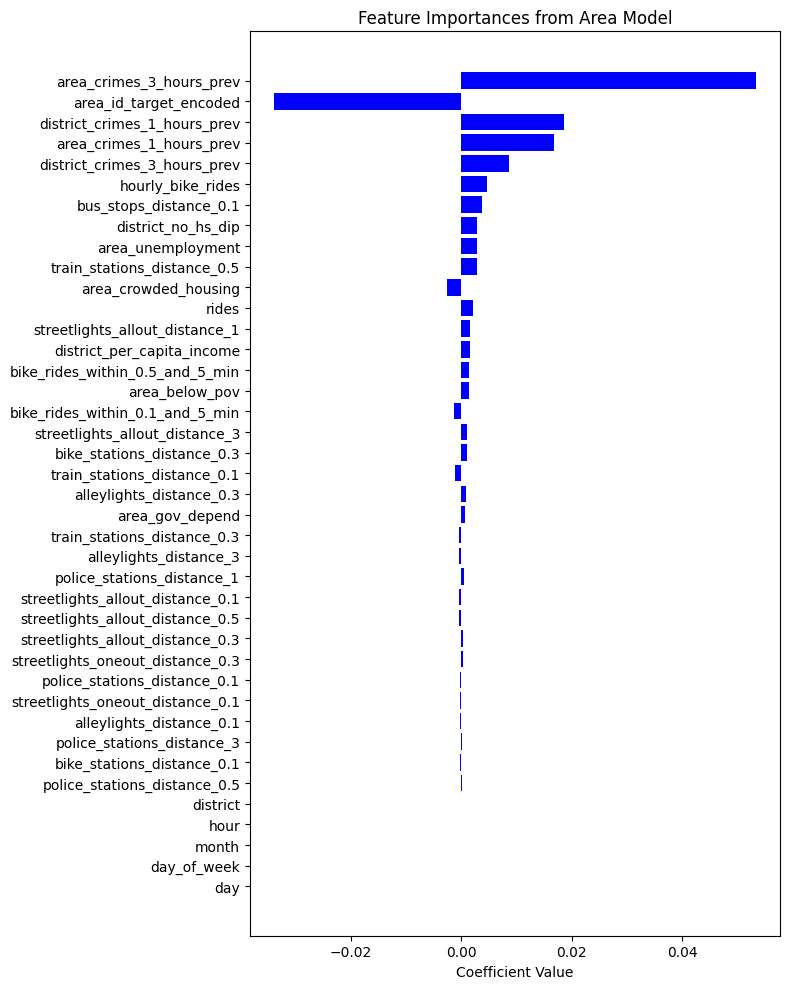

In [81]:
# Plot the coefficients
plt.figure(figsize=(8, 10))
plt.barh(area_coef_df['Feature'], area_coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importances from Area Model')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('../results/linear_regression/area_feature_coefficients.png')
plt.show()

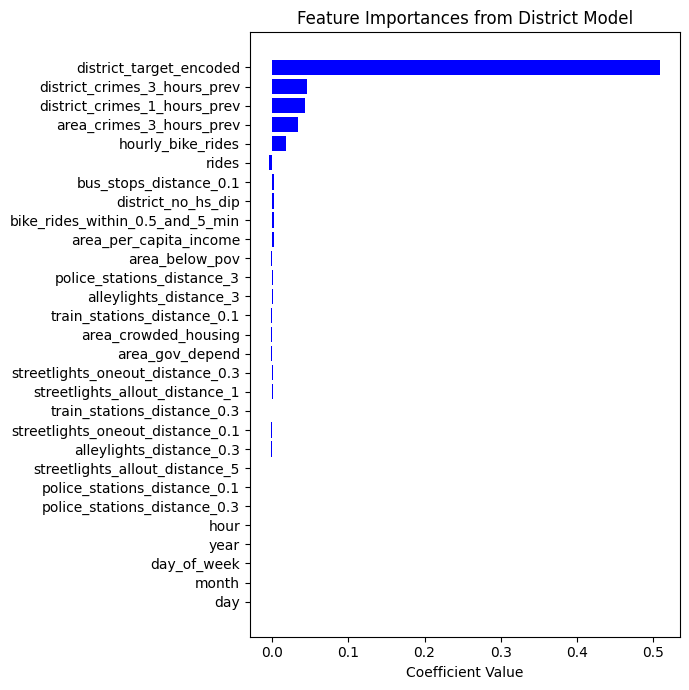

In [87]:
# Plot the coefficients
plt.figure(figsize=(7, 7))
plt.barh(district_coef_df['Feature'], district_coef_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importances from District Model')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.savefig('../results/linear_regression/district_feature_coefficients.png')
plt.show()

In [110]:
area_feature_training_data_const = sm.add_constant(area_feature_training_sample)
area_feature_testing_data_const = sm.add_constant(area_feature_testing_data)

# Fit the model using statsmodels
sm_model = sm.OLS(area_target_training_sample, area_feature_training_data_const).fit()

# Print the summary to get p-values and other statistics
print(sm_model.summary())

                              OLS Regression Results                             
Dep. Variable:     area_crimes_this_hour   R-squared:                       0.353
Model:                               OLS   Adj. R-squared:                  0.353
Method:                    Least Squares   F-statistic:                 4.204e+04
Date:                   Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                           16:38:16   Log-Likelihood:             1.2853e+07
No. Observations:                3088674   AIC:                        -2.571e+07
Df Residuals:                    3088633   BIC:                        -2.570e+07
Df Model:                             40                                         
Covariance Type:               nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [101]:
district_feature_training_sample_const = sm.add_constant(district_feature_training_sample)
district_feature_testing_data_const = sm.add_constant(district_feature_testing_data)

# Fit the model using statsmodels
sm_model = sm.OLS(district_target_training_sample, district_feature_training_sample_const).fit()

# Print the summary to get p-values and other statistics
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.208
Method:                 Least Squares   F-statistic:                     5220.
Date:                Wed, 07 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:31:34   Log-Likelihood:             2.2145e+06
No. Observations:              577248   AIC:                        -4.429e+06
Df Residuals:                  577218   BIC:                        -4.429e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

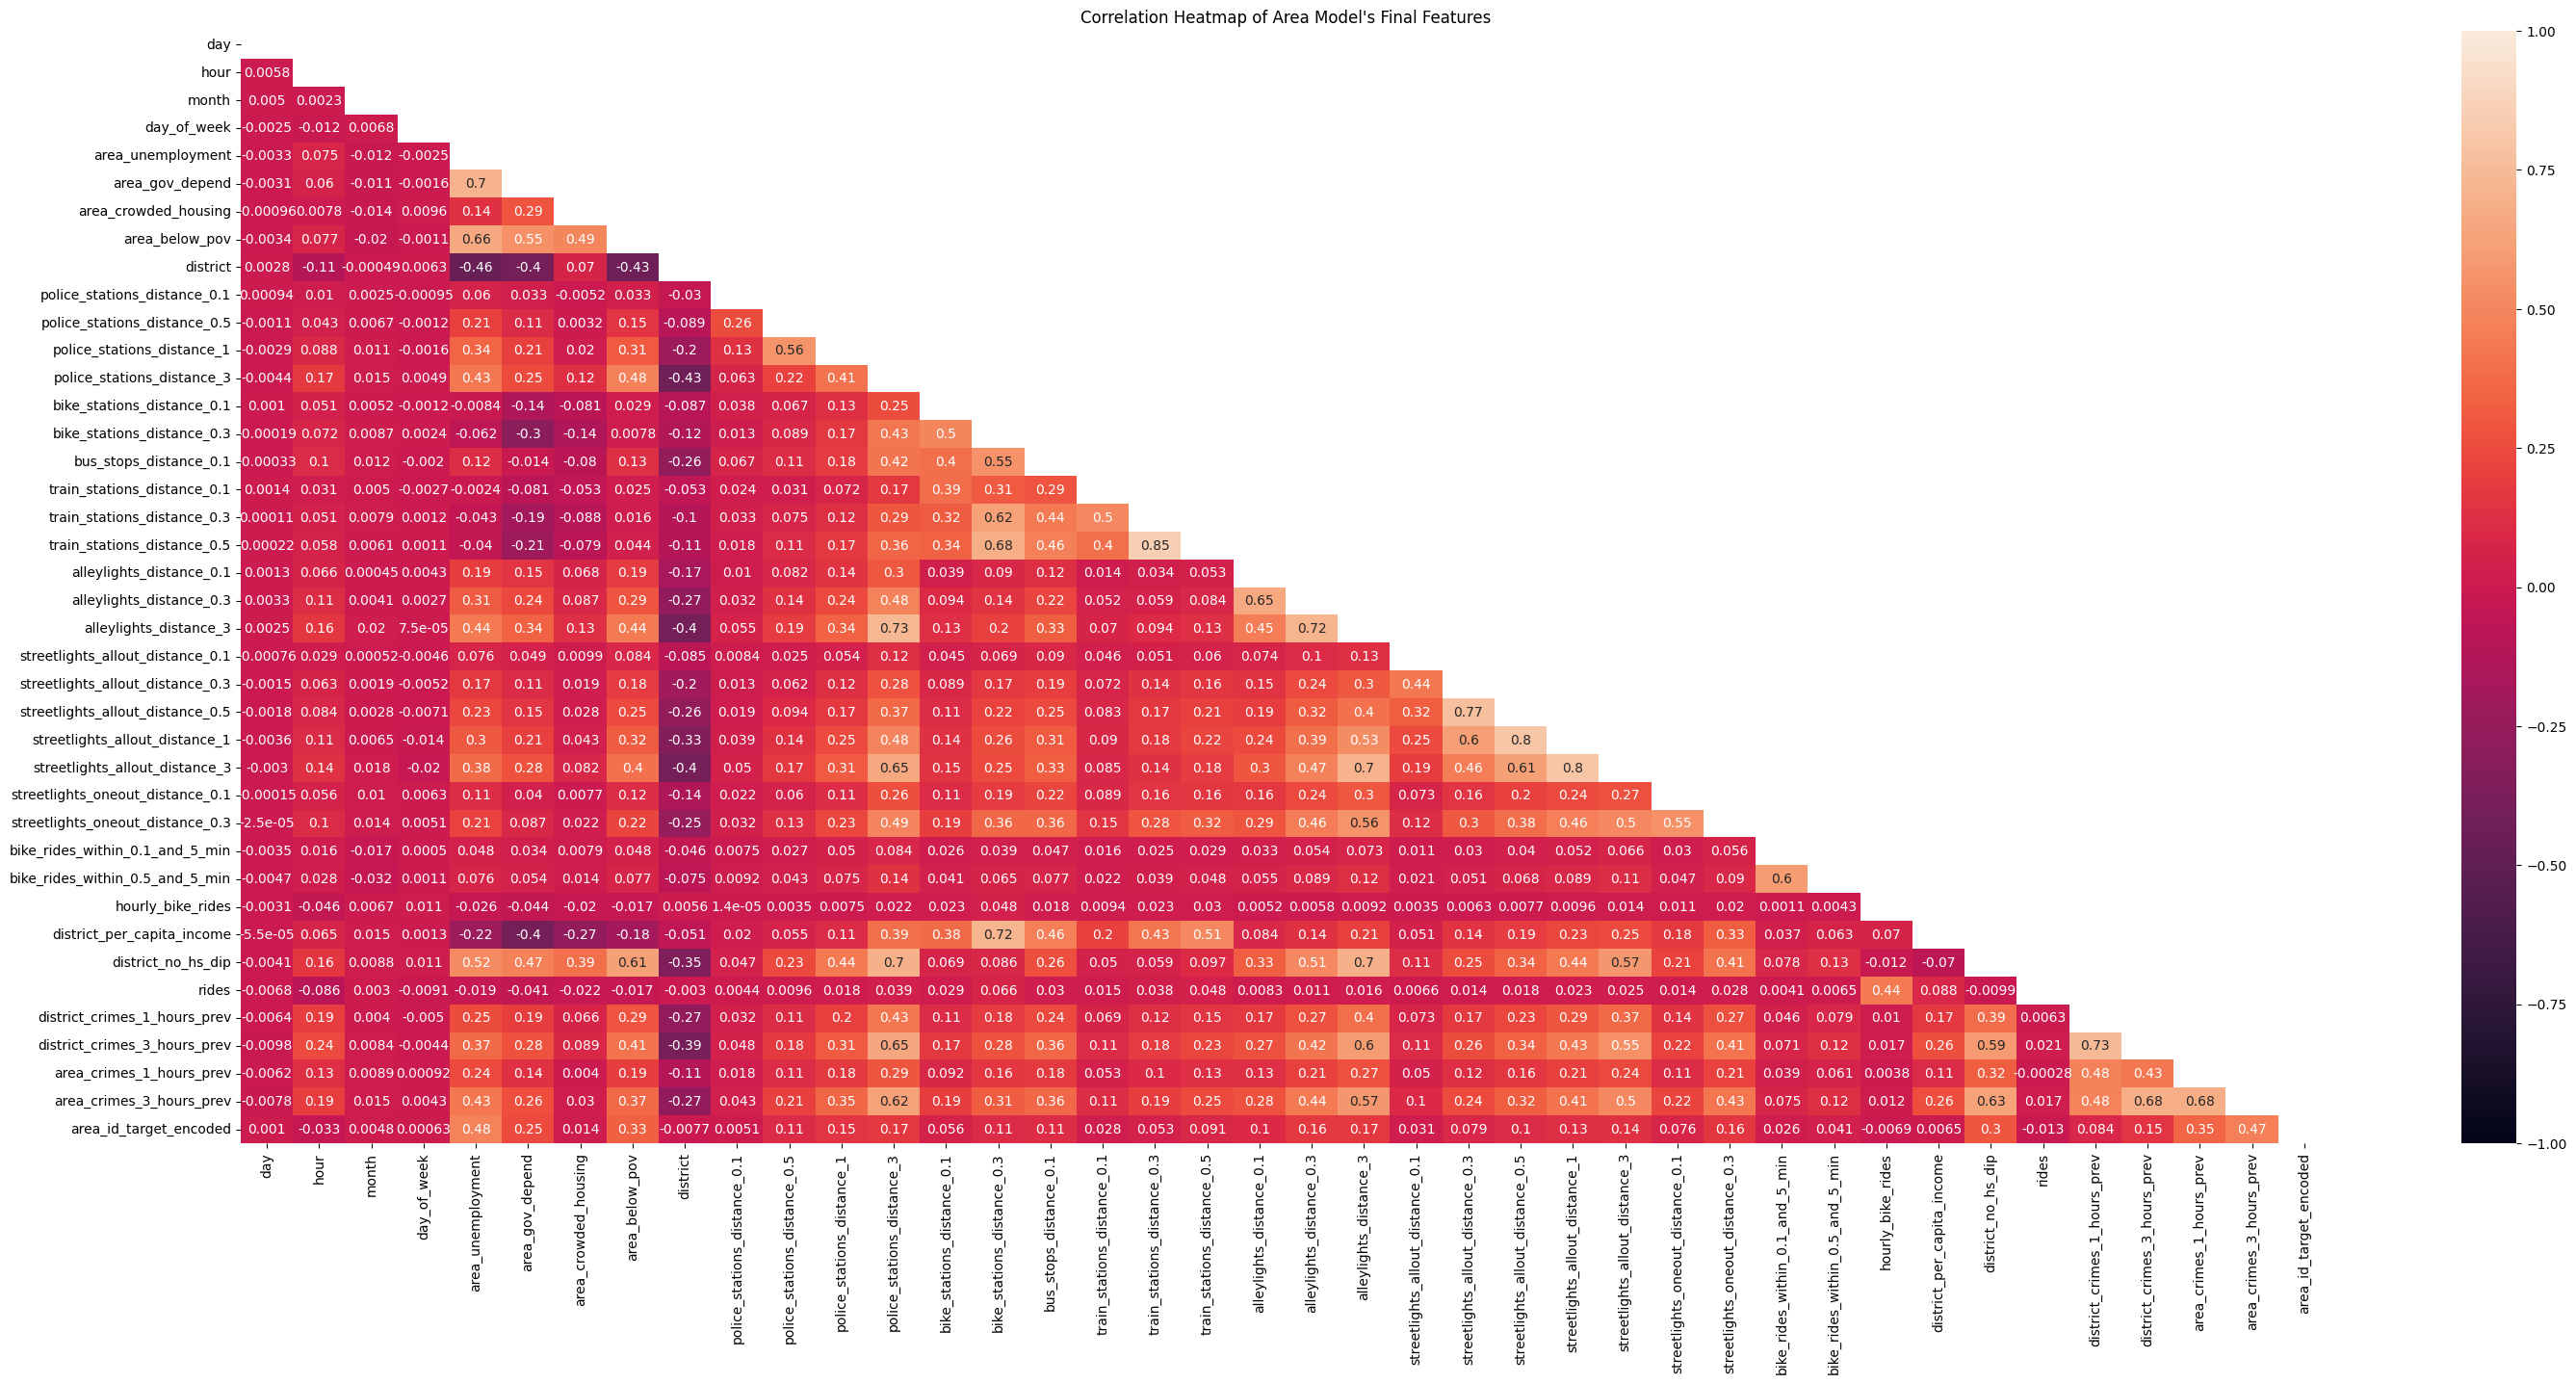

In [100]:
generate_correlation_heatmap(area_feature_training_sample, (35, 15), "Correlation Heatmap of Area Model's Final Features", 'area_final_features_corr')

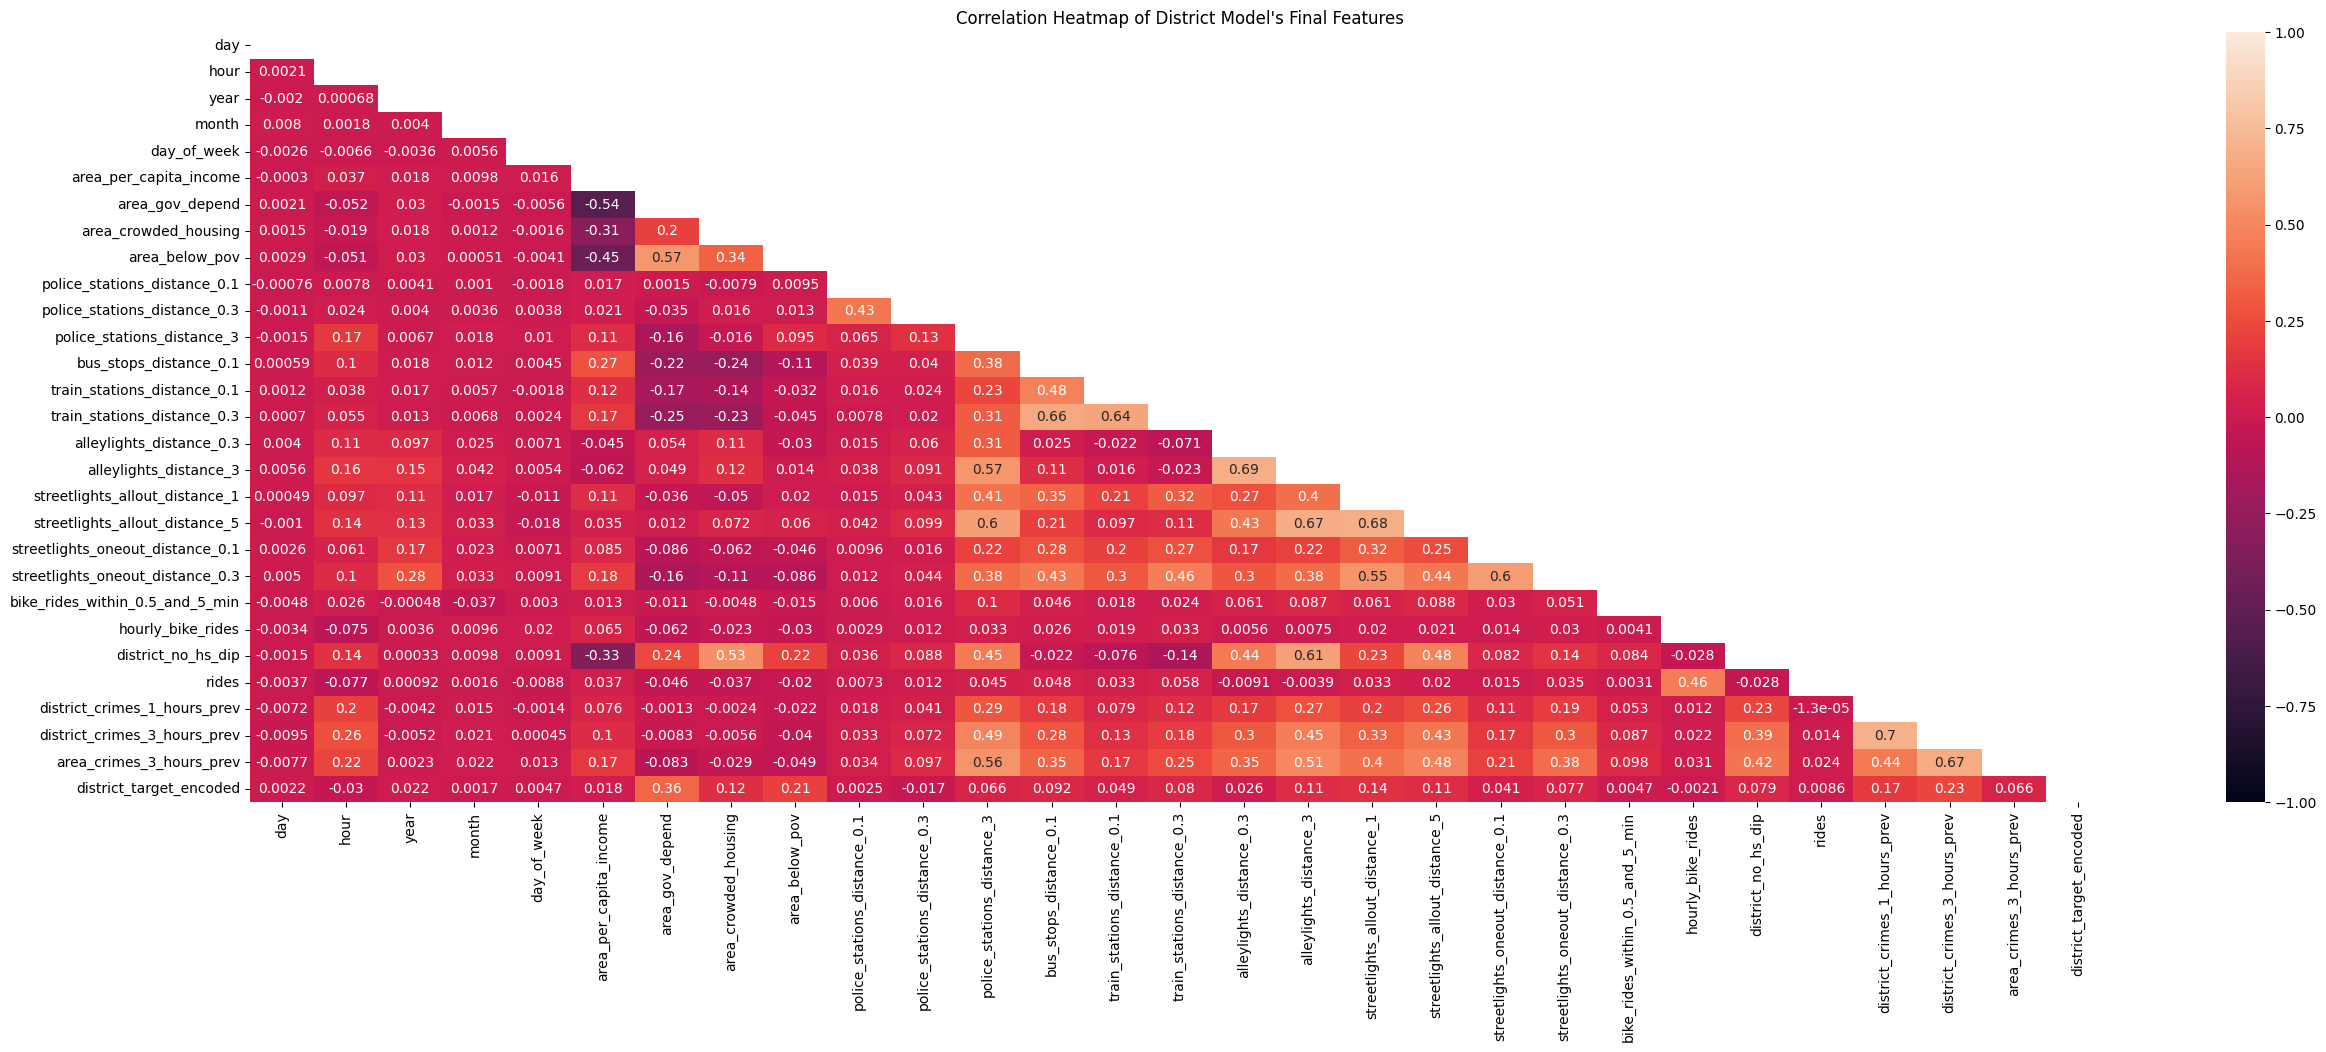

In [98]:
generate_correlation_heatmap(district_feature_training_sample, (30,10), "Correlation Heatmap of District Model's Final Features", 'district_final_features_corr')